# Land Use / Land Cover Modelling of Satellite Imagery using K-means Clustering Algorithm

## Importing Libraries

In [ ]:
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.2 MB/s 
     |████████████████████████████████| 1.0 MB 55.2 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 6.3 MB 47.6 MB/s 
     |████████████████████████████████| 16.7 MB 27.5 MB/s 


In [ ]:
from glob import glob
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio
from rasterio.plot import plotting_extent, show, reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

## Read Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
S_sentinel_bands = glob("/content/drive/MyDrive/SpatialModeling/Satellite_Imagery_Analysis-main/Clustering/Aquileia_Italy/*B?*.tiff")
S_sentinel_bands.sort()
S_sentinel_bands

['/content/drive/MyDrive/SpatialModeling/Satellite_Imagery_Analysis-main/Clustering/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/content/drive/MyDrive/SpatialModeling/Satellite_Imagery_Analysis-main/Clustering/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/content/drive/MyDrive/SpatialModeling/Satellite_Imagery_Analysis-main/Clustering/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/content/drive/MyDrive/SpatialModeling/Satellite_Imagery_Analysis-main/Clustering/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/content/drive/MyDrive/SpatialModeling/Satellite_Imagery_Analysis-main/Clustering/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/content/drive/MyDrive/SpatialModeling/Satellite_Imagery_Analysis-main/Clustering/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/content

In [ ]:
l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))
arr_st = np.stack(l)
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 689
Width: 1200
Bands: 12


## Data Visualization

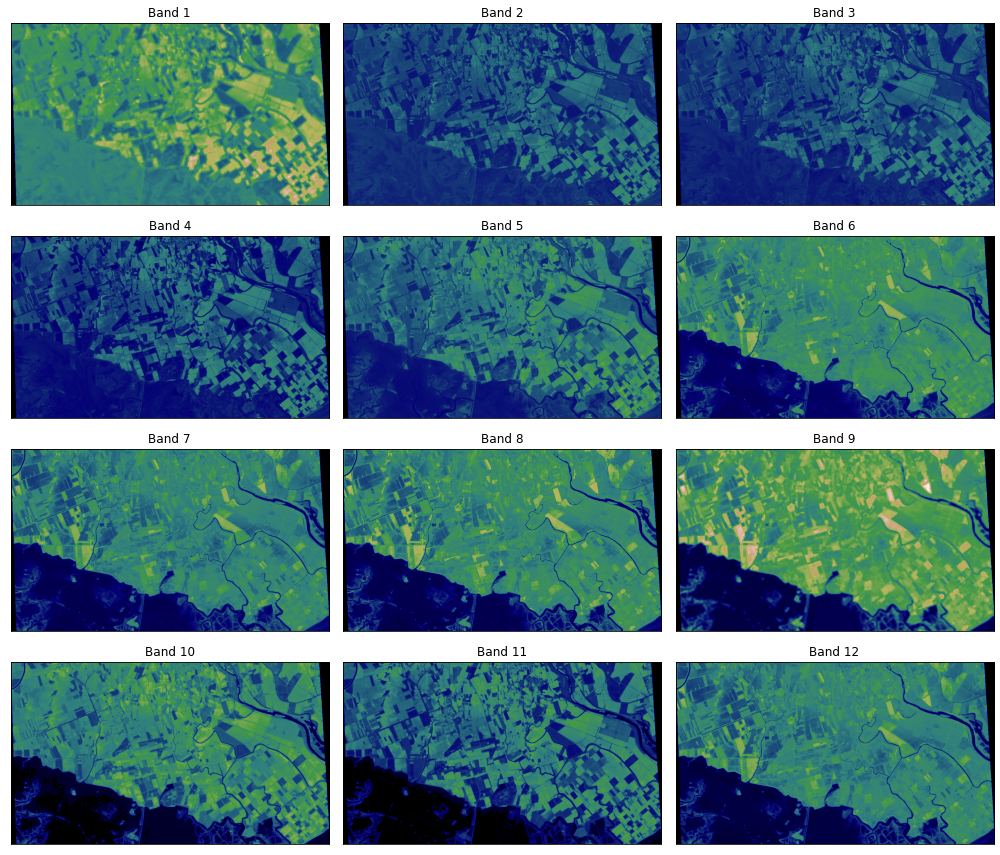

In [ ]:
# Bands
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (14, 12), cols = 3, cbar = False)
plt.show()

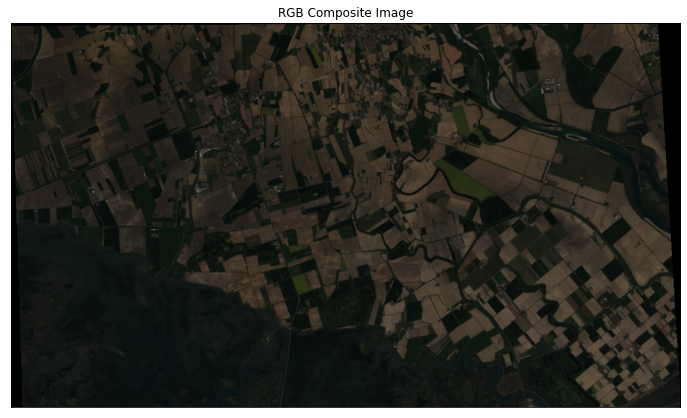

In [ ]:
# RGB Composite Image
rgb = ep.plot_rgb(arr_st, rgb=(3,2,1), figsize=(12, 16),title='RGB Composite Image')
plt.show()

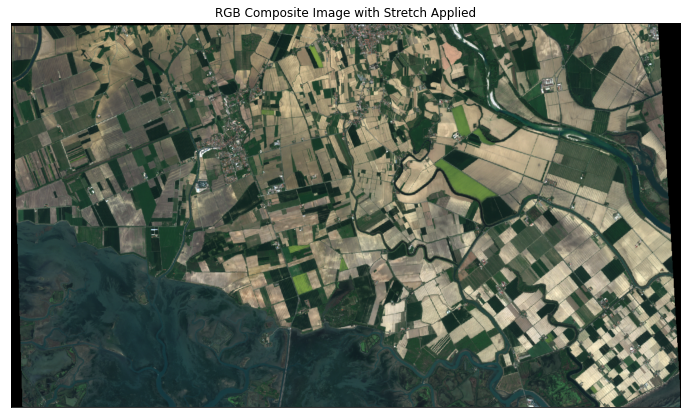

In [ ]:
ep.plot_rgb(arr_st, rgb=(3, 2, 1), stretch=True, str_clip=0.02, figsize=(12, 16),title="RGB Composite Image with Stretch Applied")
plt.show()

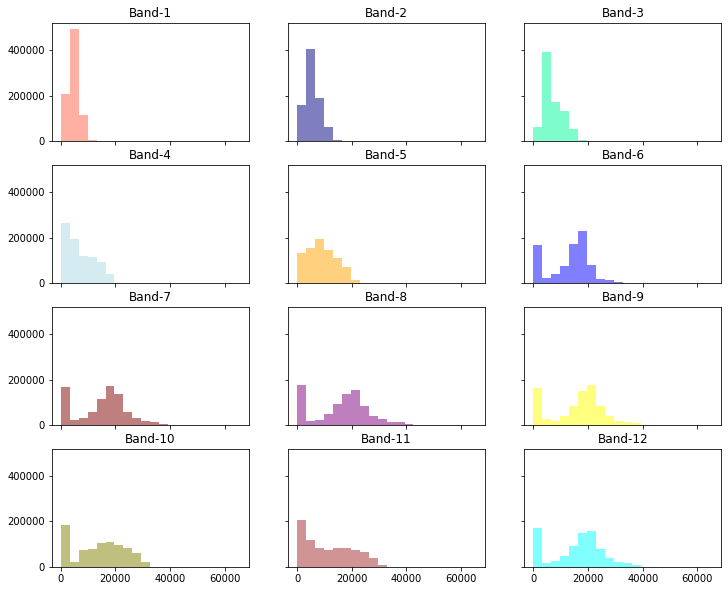

In [ ]:
# Data Distribution of Bands
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue','maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']
ep.hist(arr_st, colors = colors, title=[f'Band-{i}' for i in range(1, 13)], cols=3, alpha=0.5, figsize = (12, 10))
plt.show()

## Pre-processing 

In [ ]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(689, 1200, 12)

In [ ]:
x.reshape(-1, 12).shape, 954*298

((826800, 12), 284292)

In [ ]:
X_data = x.reshape(-1, 12)
scaler = StandardScaler().fit(X_data)
X_scaled = scaler.transform(X_data)
X_scaled.shape

(826800, 12)

In [ ]:
# Principal Component Analysis (PCA)
pca = PCA(n_components = 4)
pca.fit(X_scaled)
data = pca.transform(X_scaled)
data.shape

(826800, 4)

In [ ]:
pca.explained_variance_ratio_

array([0.68953814, 0.27498282, 0.01739938, 0.00944748])

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.9913678224195861

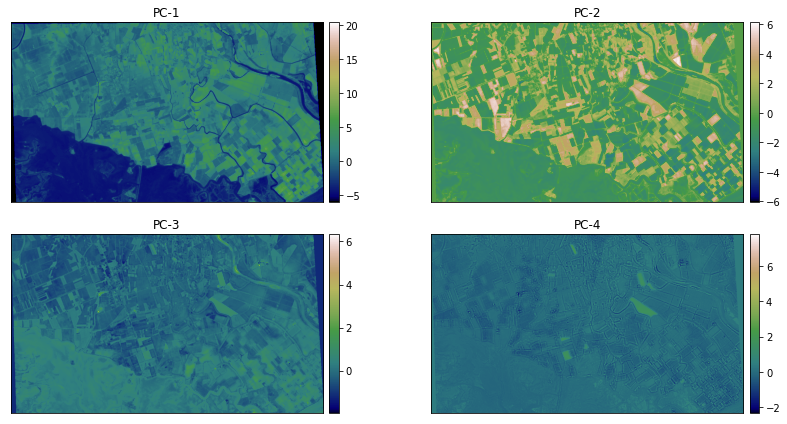

In [ ]:
# Visualize Bands after PCA
ep.plot_bands(np.moveaxis(data.reshape((689, 1200, data.shape[1])), -1, 0), cmap = 'gist_earth', cols = 2, figsize = (12, 6), title = [f'PC-{i}' for i in range(1,5)])
plt.show()

## K-means Clustering Algorithm

In [ ]:
kmeans = KMeans(n_clusters = 30, random_state = 11)
kmeans.fit(data)

KMeans(n_clusters=30, random_state=11)

In [ ]:
labels = kmeans.predict(data)
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

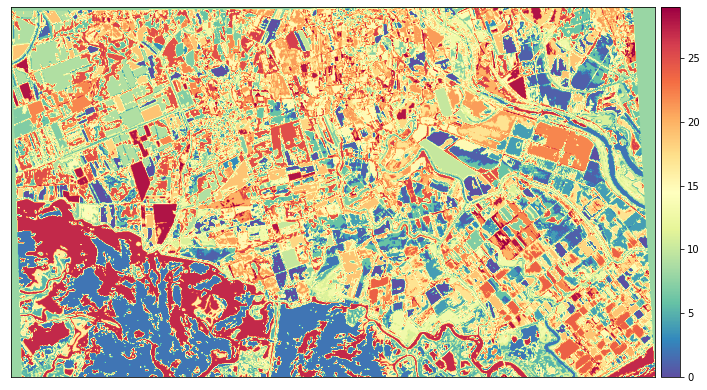

In [ ]:
# Visualize labels predicted by K-means Algorithm
ep.plot_bands(labels.reshape(689, 1200), figsize = (12, 16), cmap='Spectral_r')
plt.show()

In [ ]:
# Interactive plot using Plotly
fig = px.imshow(labels.reshape(689, 1200), color_continuous_scale ='Spectral_r')
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(autosize=False, width=1200, height=698, margin=dict(l=50, r=50, b=100, t=100, pad=4),paper_bgcolor="LightSteelBlue",)



---

